# Implementing a retinotopic transform using `grid_sample` from `pyTorch`

The [grid_sample](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) transform is a powerful function which allows to transform any input image into a new topology. It is notably used in [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025) for instance to learn CNN to be invariant to affine transforms. We used it recently in a publication [What You See Is What You Transform: Foveated Spatial Transformers as a Bio-Inspired Attention Mechanism](https://laurentperrinet.github.io/publication/dabane-22/) by Ghassan Dabane *et al*.

The use of `grid_sample` can b etedious and here, we show how to use it to create a log-polar transform of the image and create the following figure:

![Retinotopy](ICLR_fig-logpolar.png)

> A picture (extract from the painting ["The Ambassadors" by Hans Holbein the Younger](https://en.wikipedia.org/wiki/The_Ambassadors_(Holbein))) can be represented on a regular grid represented by vertical (red) and horizontal (blue) lines. Retinotopy transforms this grid, and in particular the area representing the fovea (shaded gray) is over-represented. Applied to the original image of the portrait, the image is strongly distorted and represents more finally the parts under the axis of sight (here the mouth).


<!-- TEASER_END -->

Let's first initialize the notebook :

In [ ]:
import retinoto_py as fovea
args = fovea.Params()
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=True, seed=1998, batch_size=64, num_workers=4, model_name='resnet101', do_scratch=False, num_epochs=50, n_train_stop=19200, n_val_stop=6400, lr=0.0001, delta1=0.05, delta2=0.001, weight_decay=0.0, shuffle=True, verbose=True)

In [1]:
import os

import numpy as np
import torch
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)
import torch.nn.functional as F

import matplotlib.pyplot as plt
fig_width = 15
# https://github.com/laurentperrinet/PerrinetBednar15/blob/218b0fa8f114c07ec5f4ba2f6149e461eeb57bf7/notebooks/4%20notebook_figure_results.ipynb#L141
fig_width_points = 1.75 * 379 # % \showthe\columnwidth
inches_per_point = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_points*inches_per_point  # width in inches

# dpi_per_inch =  
# fig_width = 5
dpi = 'figure'
dpi = 100
dpi = 200
opts_savefig = dict(bbox_inches='tight',  dpi=dpi, pad_inches=0, edgecolor=None) # transparent=True

image_size_grid = 257

## definition of the grid

Let's first define a first grid as a set of points defined in absolute coordinates between $-1$ and $1$, and define the corresponding meshgrid:

In [2]:
image_size = 360
image_size_az, image_size_el = image_size, image_size
rs_ = torch.logspace(0, -4, image_size_az, base=2)
ts_ = torch.linspace(-torch.pi, torch.pi, image_size_el+1)[:-1]

grid_xs = torch.outer(rs_, -torch.cos(ts_)) 
grid_ys = torch.outer(rs_, torch.sin(ts_)) 
grid_xs.shape, grid_ys.shape

(torch.Size([360, 360]), torch.Size([360, 360]))

These are then formated in the right format to be used by the function:

In [3]:
center_x, center_y = 0., 0. # defines the fixation point's center in absolute coordinates
logPolar_grid = torch.stack((grid_xs-center_x, grid_ys-center_y), 2)
logPolar_grid = logPolar_grid.unsqueeze(0) # add batch dim
logPolar_grid.shape

torch.Size([1, 360, 360, 2])

In [4]:
logPolar_grid.min()

tensor(-1.)

In [5]:
# F.grid_sample?

## application to a synthetic image

We define a synthetic image to illustrate the transform, it consists of white pixels, red verticals and blue horizontals, regularly spaced:

In [6]:
image_grid_size = 8
image_grid_tens = torch.ones((3, image_size_grid, image_size_grid)).float()
image_grid_tens[0:2, ::image_grid_size, :] = 0
image_grid_tens[1:3, :, ::image_grid_size] = 0.5
fovea_size = 5
image_grid_tens[[0, 2], 
                int(image_size_grid//2+image_grid_size*fovea_size/2.5):int(image_size_grid//2+image_grid_size*fovea_size), 
                int(image_size_grid//2+image_grid_size*fovea_size/2.5):int(image_size_grid//2+image_grid_size*fovea_size), 
                ] = 0
image_grid_tens[[0, 2], 
                int(image_size_grid//2+image_grid_size*fovea_size):int(image_size_grid//2+image_grid_size*fovea_size*2), 
                int(image_size_grid//2-image_grid_size*fovea_size*2):int(image_size_grid//2-image_grid_size*fovea_size), 
                ] = 0
image_grid_tens[:, (image_size_grid//2-image_grid_size*fovea_size):(image_size_grid//2+image_grid_size*fovea_size), (image_size_grid//2-image_grid_size*fovea_size):(image_size_grid//2+image_grid_size*fovea_size)] *= .5
image_grid_tens.shape, image_grid_tens.unsqueeze(0).shape

(torch.Size([3, 257, 257]), torch.Size([1, 3, 257, 257]))

to display it, we need to transform the torch format to a numpy / matplotlib compatible one, which can be first tested on a MWE (minimal working example) using `torch.movedim`:

In [7]:
torch.movedim(torch.randn(1, 2, 3), (0, 1, 2), (1, 2, 0)).shape

torch.Size([3, 1, 2])

this can be done on the image in a few lines:

In [8]:
image_grid = image_grid_tens.squeeze(0)
# swap from C, H, W (torch) to H, W, C (numpy)
image_grid = torch.movedim(image_grid, (1, 2, 0), (0, 1, 2))
image_grid = image_grid.numpy()
image_grid.shape

(257, 257, 3)

so that we can display the synthetic image:

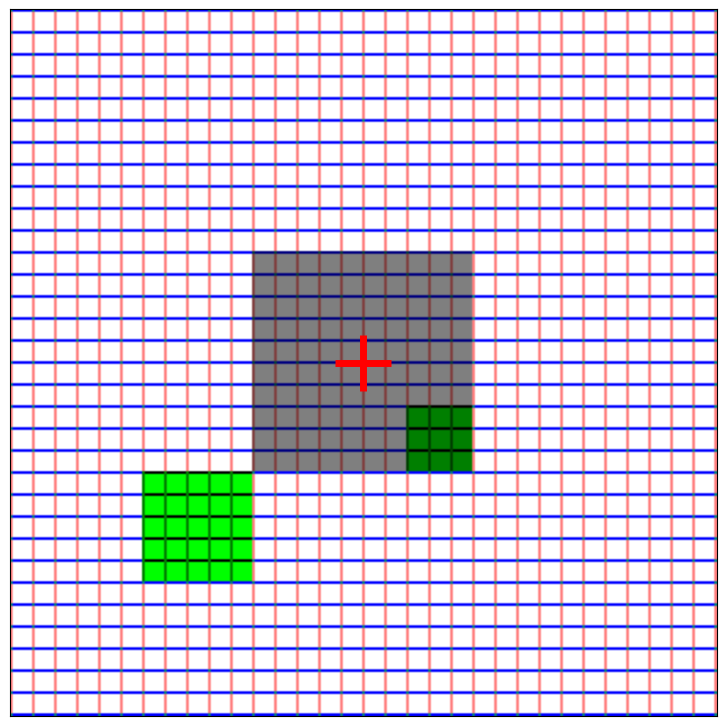

In [9]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_grid)
ax.plot(image_size_grid//2, image_size_grid//2, 'r+', markersize=40, markeredgewidth=5)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

Let's transform the image of the grid:

In [10]:
image_grid_ret_tens = F.grid_sample(image_grid_tens.unsqueeze(0).float(), logPolar_grid, align_corners=False, padding_mode='border')
image_grid_tens.shape, logPolar_grid.shape, image_grid_ret_tens.shape

(torch.Size([3, 257, 257]),
 torch.Size([1, 360, 360, 2]),
 torch.Size([1, 3, 360, 360]))

and transform it back to numpy:

In [11]:
image_grid_ret_tens = image_grid_ret_tens.squeeze(0)
# swap from C, H, W (torch) to H, W, C (numpy)
image_grid_ret_tens = torch.movedim(image_grid_ret_tens, (1, 2, 0), (0, 1, 2))
image_grid_ret = image_grid_ret_tens.numpy()
image_grid_ret /= image_grid_ret.max()
image_grid_ret.shape

(360, 360, 3)

to then display the retinotopic transform of the grid image:

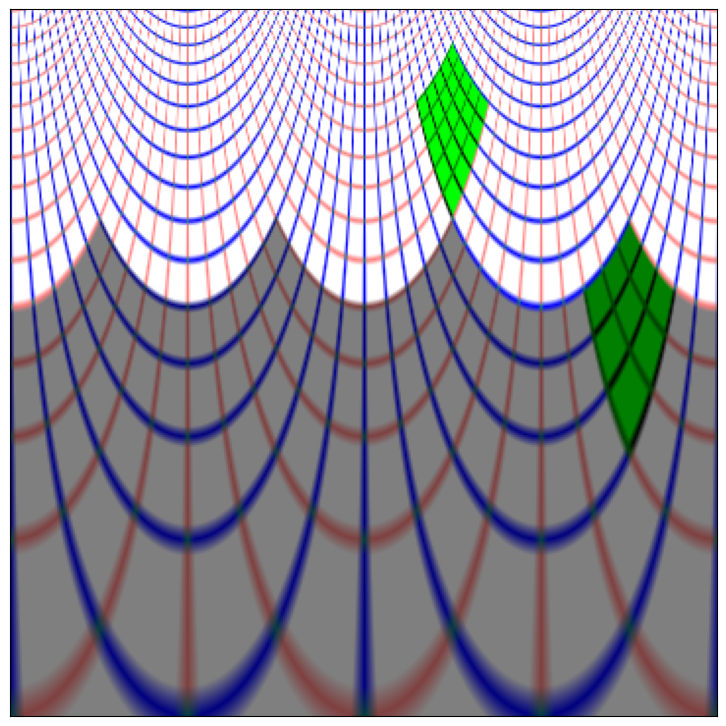

In [12]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_grid_ret)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

## application to a natural image

Let's load an image by extracting a part from the painting ["The Ambassadors" by Hans Holbein the Younger](https://en.wikipedia.org/wiki/The_Ambassadors_(Holbein)) or to any other image:

In [13]:
# image_size = 380
# image_size_az, image_size_el = image_size, image_size
# rs_ = torch.logspace(0, -4, image_size_az, base=2)
# ts_ = torch.linspace(-torch.pi, torch.pi, image_size_el+1)[:-1]

# grid_xs = torch.outer(rs_, -torch.cos(ts_)) 
# grid_ys = torch.outer(rs_, torch.sin(ts_)) 
# grid_xs.shape, grid_ys.shape

In [14]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/8/88/Hans_Holbein_the_Younger_-_The_Ambassadors_-_Google_Art_Project.jpg'
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Hans_Holbein_the_Younger_-_The_Ambassadors_-_Google_Art_Project.jpg/608px-Hans_Holbein_the_Younger_-_The_Ambassadors_-_Google_Art_Project.jpg'

im_shift_X, im_shift_Y = 0, 27

image_url = './images//jaguar_5.jpg'

In [15]:
import imageio.v2 as imageio


full_image = imageio.imread(image_url) / 255
# full_image = full_image[::2, ::2, :] # downscale to reduce file size
# N_X, N_Y, three = image.shape
print(full_image.shape)

(587, 800, 3)


In [16]:
print (full_image.min(), full_image.max())

0.0 1.0


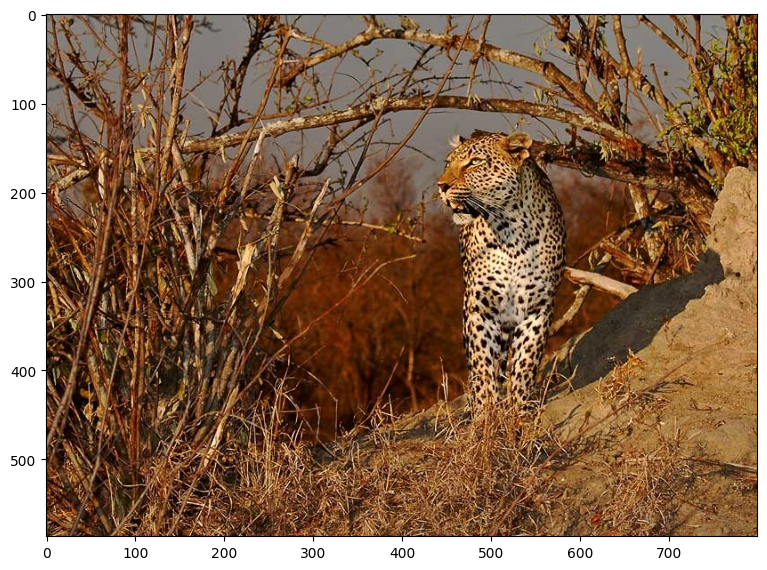

In [17]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(full_image)
# ax.set_xticks([])
# ax.set_yticks([])  
fig.set_facecolor(color='white')

In [18]:

im_shift_X, im_shift_Y = 40, 150

image = full_image[im_shift_X:(im_shift_X+image_size), im_shift_Y:(im_shift_Y+image_size), :]

image.shape

(360, 360, 3)

In [19]:
print (image.min(), image.max())

0.0 1.0


In [20]:
image = (image - image.min()) / (image.max() - image.min())

In [21]:
print (image.min(), image.max())

0.0 1.0


and display it:

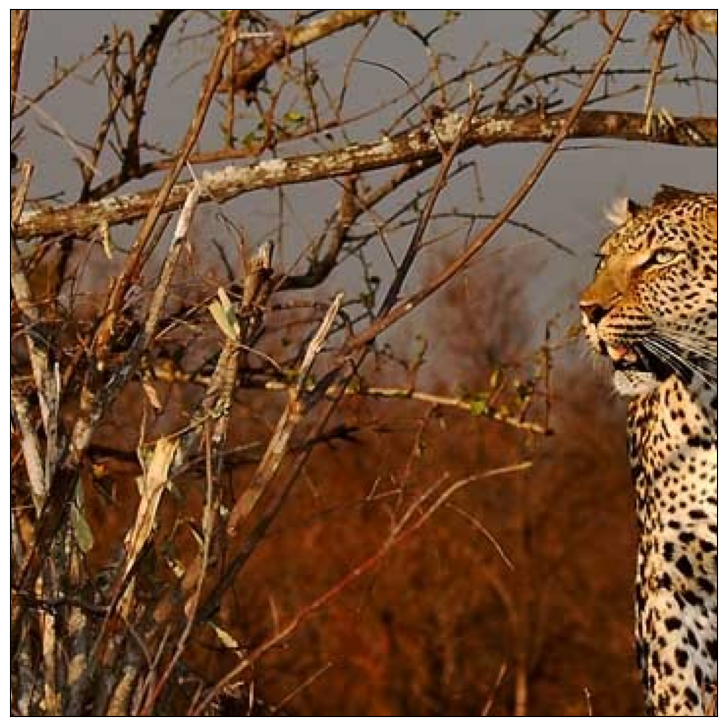

In [22]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

to use it in the function, we need to transform the numpy format to a torch compatible one, which can be first tested on a MWE (minimal working example):

In [23]:
torch.movedim(torch.randn(1, 2, 3), (1, 2, 0), (0, 1, 2)).shape

torch.Size([2, 3, 1])

this now looks like:

In [24]:
image_tens = torch.from_numpy(image)
# swap from H, W, C (numpy) to C, H, W (torch)
image_tens = torch.movedim(image_tens, (0, 1, 2), (1, 2, 0))
image.shape, image_tens.shape

((360, 360, 3), torch.Size([3, 360, 360]))

Let's transform the image:

In [25]:
image_ret_tens = F.grid_sample(image_tens.unsqueeze(0).float(), logPolar_grid, align_corners=False, padding_mode='border')
image_ret_tens.shape

torch.Size([1, 3, 360, 360])

and transform it back to numpy:

In [26]:
image_ret_tens = image_ret_tens.squeeze(0)
# swap from C, H, W (torch) to H, W, C (numpy)
image_ret_tens = torch.movedim(image_ret_tens, (1, 2, 0), (0, 1, 2))
image_ret = image_ret_tens.numpy()

and display it:

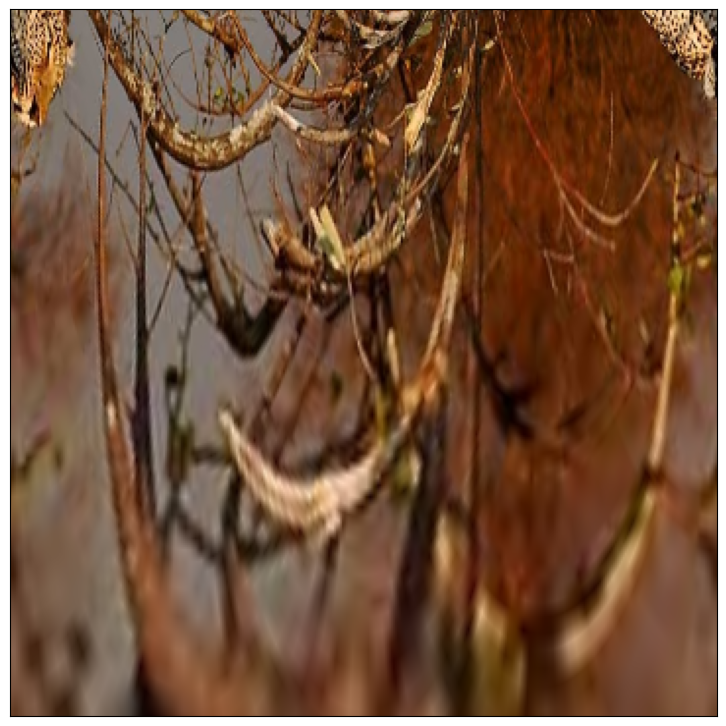

In [27]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_ret)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

Make a plot in linear-polar coordinates:

[]

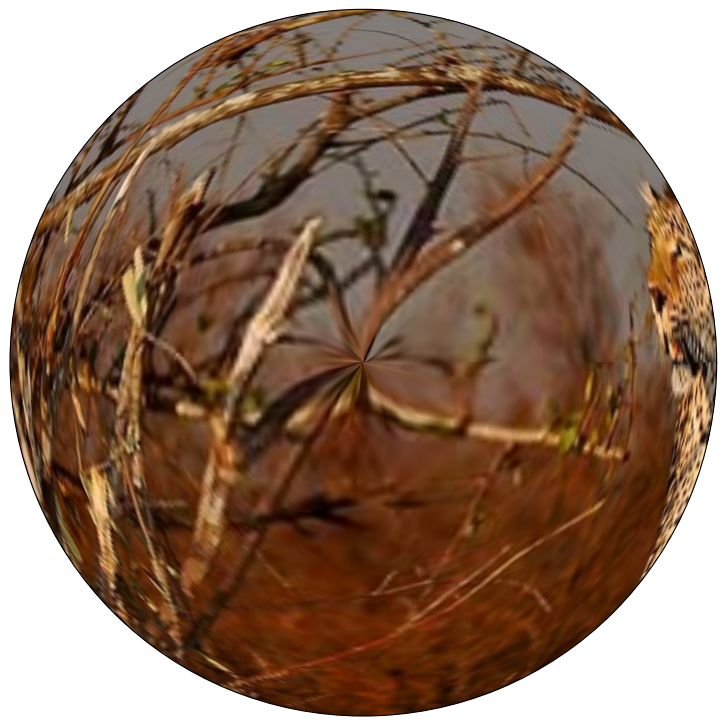

In [28]:
# get coordinates of boxes in the mesh :
phi = np.linspace(0, 2*np.pi, image_ret.shape[1])
r = np.linspace(0, 1, image_ret.shape[0])
Phi, R = np.meshgrid(phi, r)
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width), subplot_kw=dict(polar=True))
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html
# https://matplotlib.org/devdocs/gallery/images_contours_and_fields/pcolormesh_grids.html
m = ax.pcolormesh(Phi, R, np.flipud(image_ret), shading='gouraud', vmin=image_ret.min(), vmax=image_ret.max(), 
                  edgecolors='none', linewidth=0)

from matplotlib.patches import FancyArrowPatch

# arc = FancyArrowPatch((1., 1.2), (1.2, 1.2), connectionstyle="arc3,rad=.5", arrowstyle='<->', mutation_scale=20)
# arc = FancyArrowPatch((1., 1.2), (1.2, 1.2), arrowstyle='<->', mutation_scale=20)
# arc = FancyArrowPatch((1., 1.2), (1.2, 1.2),connectionstyle="arc3,rad=.1",  arrowstyle='<->', mutation_scale=20)
# ax.add_patch(arc)
ax.set_xticks([])
ax.set_yticks([])

Take another snapshot with a different center:

In [29]:
im_shift_X, im_shift_Y = 5, 295
image_shift = full_image[im_shift_X:(im_shift_X+image_size), im_shift_Y:(im_shift_Y+image_size), :]
image_tens = torch.from_numpy(image_shift)
# swap from H, W, C (numpy) to C, H, W (torch)
image_tens = torch.movedim(image_tens, (0, 1, 2), (1, 2, 0))
image_ret_tens = F.grid_sample(image_tens.unsqueeze(0).float(), logPolar_grid, align_corners=False, padding_mode='border')
image_ret_tens = image_ret_tens.squeeze(0)
image_ret_tens = torch.movedim(image_ret_tens, (1, 2, 0), (0, 1, 2))
image_ret_shift = image_ret_tens.numpy()

In [30]:
# fig.add_subplot?

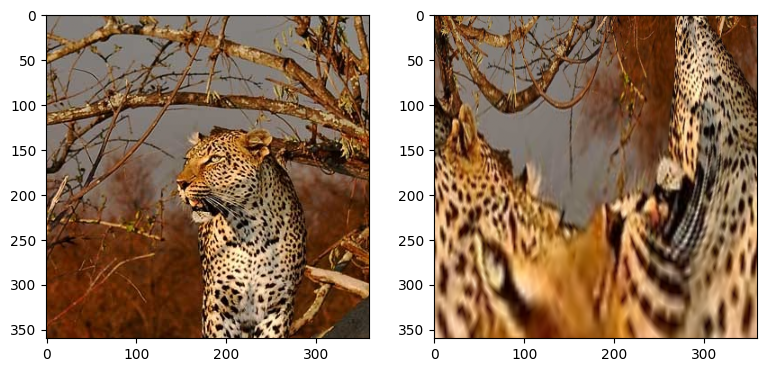

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_width))
axs[0].imshow(image_shift)
axs[1].imshow(image_ret_shift)
fig.set_facecolor(color='white')

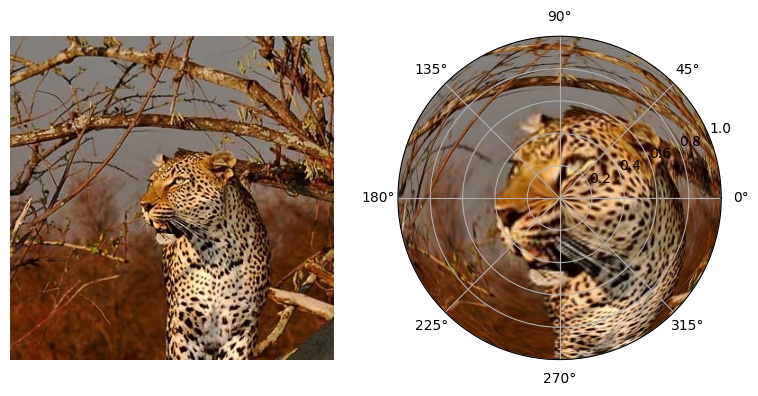

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_width/2))
axs[0].imshow(image_shift)
ax = fig.add_subplot(122, polar=True)
# axs[1].imshow(image_ret_shift)
m = ax.pcolormesh(Phi, R, np.flipud(image_ret_shift), shading='gouraud', vmin=image_ret.min(), vmax=image_ret.max(), 
                  edgecolors='none', linewidth=0)
# ax.set_thetamin(0)
# ax.set_thetamax(360)

for ax in axs :
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.get_xaxis().set_ticks([])
    # ax.get_yaxis().set_ticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
# fig.set_facecolor(color='white')

[]

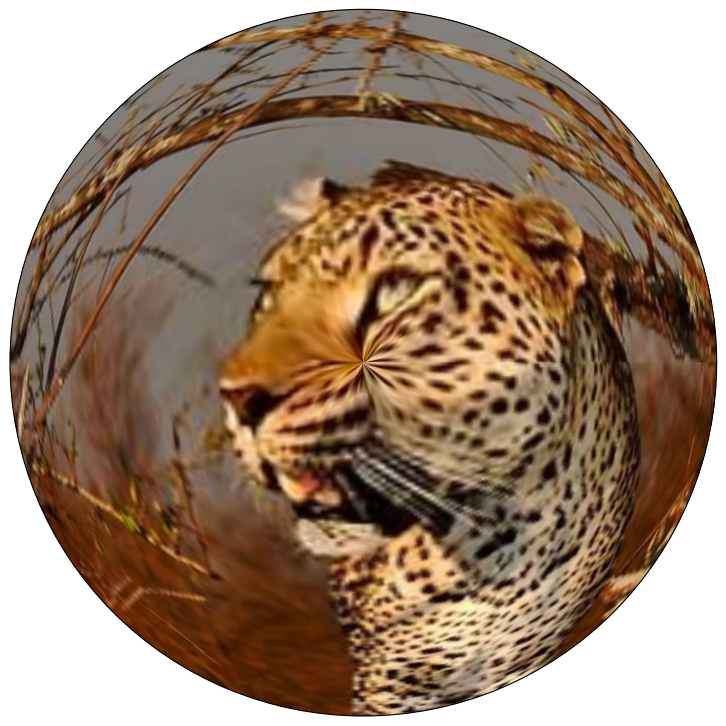

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width), subplot_kw=dict(polar=True))
m = ax.pcolormesh(Phi, R, np.flipud(image_ret_shift), shading='gouraud', vmin=image_ret.min(), vmax=image_ret.max(), 
                  edgecolors='none', linewidth=0)

ax.set_xticks([])
ax.set_yticks([])

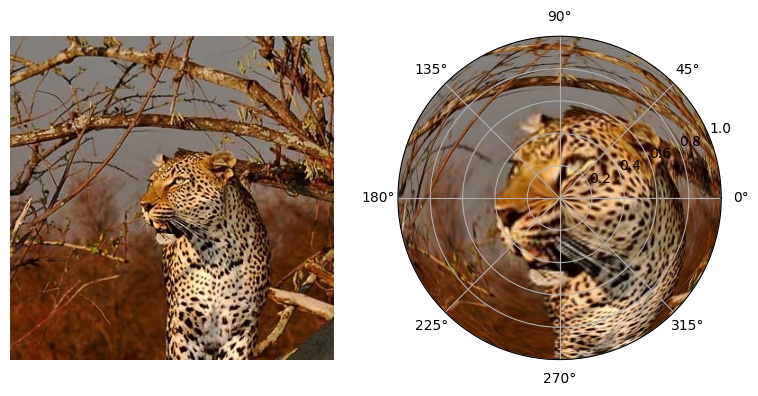

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_width/2))
axs[0].imshow(image_shift)
ax = fig.add_subplot(122, polar=True)
m = ax.pcolormesh(Phi, R, np.flipud(image_ret_shift), shading='gouraud', vmin=image_ret.min(), vmax=image_ret.max(), 
                  edgecolors='none', linewidth=0)
for ax in axs :
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
fig.set_facecolor(color='white')

## summary

### version with maps

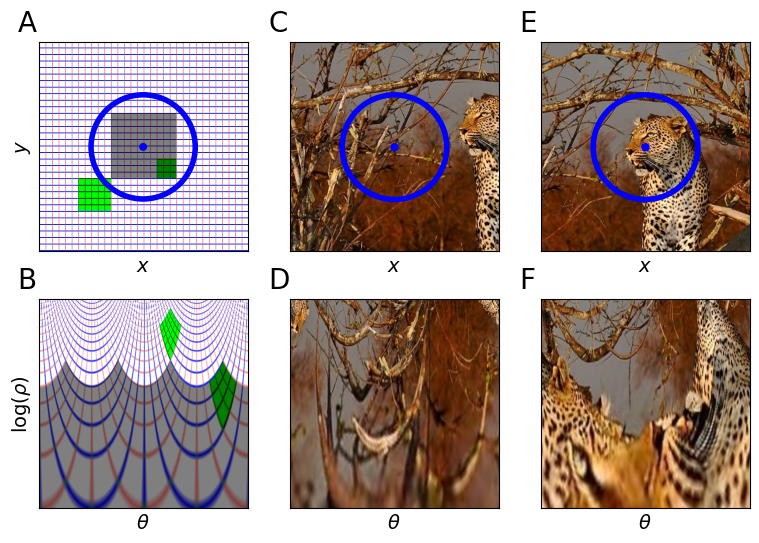

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(fig_width, fig_width*2/3))
from matplotlib.patches import Circle

ax = axs[0][0]
ax.imshow(image_grid)
# ax.plot(image_size//2, image_size//2, 'r+', markersize=20, markeredgewidth=2)
color = 'b'
circ = Circle((image_size_grid//2, image_size_grid//2), radius=(image_size_grid//60), edgecolor=color, facecolor=color)
ax.add_patch(circ)
circ = Circle((image_size_grid//2, image_size_grid//2), radius=(image_size_grid//4), lw=4, edgecolor=color, facecolor='none')
ax.add_patch(circ)
ax.text(-.1, 1.05, 'A', fontsize=20, color='black', transform=ax.transAxes)
# ax.plot(image_size_grid//2, image_size_grid//2, 'r+', markersize=20, markeredgewidth=2)
ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$y$', fontsize=14)
ax = axs[1][0]
ax.imshow(image_grid_ret)
ax.text(-.1, 1.05, 'B', fontsize=20, color='black', transform=ax.transAxes)
ax.set_xlabel(r'$\theta$', fontsize=14)
ax.set_ylabel(r'log($\rho$)', fontsize=14)

ax = axs[0][1]
ax.imshow(image)
circ = Circle((image_size//2, image_size//2), radius=(image_size//60), edgecolor=color, facecolor=color)
ax.add_patch(circ)
circ = Circle((image_size//2, image_size//2), radius=(image_size//4), lw=4, edgecolor=color, facecolor='none')
ax.add_patch(circ)
ax.set_xlabel(r'$x$', fontsize=14)
ax.text(-.1, 1.05, 'C', fontsize=20, color='black', transform=ax.transAxes)
ax = axs[1][1]
ax.imshow(image_ret)
ax.set_xlabel(r'$\theta$', fontsize=14)
ax.text(-.1, 1.05, 'D', fontsize=20, color='black', transform=ax.transAxes)

ax = axs[0][2]
ax.imshow(image_shift)
circ = Circle((image_size//2, image_size//2), radius=(image_size//60), edgecolor=color, facecolor=color)
ax.add_patch(circ)
circ = Circle((image_size//2, image_size//2), radius=(image_size//4), lw=4, edgecolor=color, facecolor='none')
ax.add_patch(circ)
ax.set_xlabel(r'$x$', fontsize=14)
ax.text(-.1, 1.05, 'E', fontsize=20, color='black', transform=ax.transAxes)
ax = axs[1][2]
ax.imshow(image_ret_shift)
ax.set_xlabel(r'$\theta$', fontsize=14)
ax.text(-.1, 1.05, 'F', fontsize=20, color='black', transform=ax.transAxes)

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])  
fig.set_facecolor(color='white')


In [36]:
# if do_save: to_save(fig, name='fig-logpolar')

### version with reconstructions


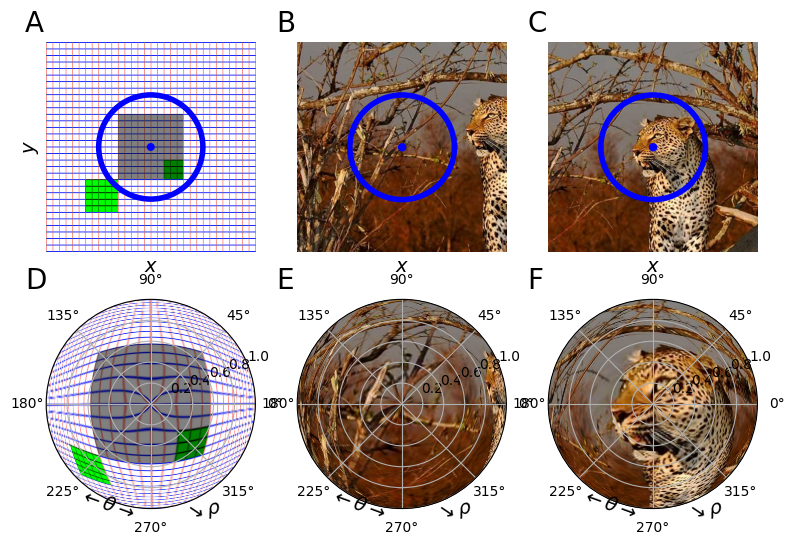

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(fig_width, fig_width*2/3))
from matplotlib.patches import Circle

ax = axs[0][0]
ax.imshow(image_grid)
# ax.plot(image_size//2, image_size//2, 'r+', markersize=20, markeredgewidth=2)
color = 'b'
circ = Circle((image_size_grid//2, image_size_grid//2), radius=(image_size_grid//60), edgecolor=color, facecolor=color)
ax.add_patch(circ)
circ = Circle((image_size_grid//2, image_size_grid//2), radius=(image_size_grid//4), lw=4, edgecolor=color, facecolor='none')
ax.add_patch(circ)
ax.text(-.1, 1.05, 'A', fontsize=20, color='black', transform=ax.transAxes)
# ax.plot(image_size_grid//2, image_size_grid//2, 'r+', markersize=20, markeredgewidth=2)
ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$y$', fontsize=14)
# ax = axs[1][0]
ax = fig.add_subplot(2, 3, 4, polar=True)
m = ax.pcolormesh(Phi, R, np.flipud(image_grid_ret), shading='gouraud', vmin=image_grid_ret.min(), vmax=image_grid_ret.max(), 
                  edgecolors='none', linewidth=0)

# ax.imshow(image_grid_ret)
ax.text(-.1, 1.05, 'D', fontsize=20, color='black', transform=ax.transAxes)
ax.text(.15, -.05, r'$\leftarrow\theta\rightarrow$', fontsize=14, color='black', transform=ax.transAxes, rotation=-20)
ax.text(.65, -.05, r'$\searrow \rho$', fontsize=14, color='black', transform=ax.transAxes, rotation=10)

ax = axs[0][1]
ax.imshow(image)
circ = Circle((image_size//2, image_size//2), radius=(image_size//60), edgecolor=color, facecolor=color)
ax.add_patch(circ)
circ = Circle((image_size//2, image_size//2), radius=(image_size//4), lw=4, edgecolor=color, facecolor='none')
ax.add_patch(circ)
ax.set_xlabel(r'$x$', fontsize=14)
ax.text(-.1, 1.05, 'B', fontsize=20, color='black', transform=ax.transAxes)
# ax = axs[1][1]
ax = fig.add_subplot(2, 3, 5, polar=True)
m = ax.pcolormesh(Phi, R, np.flipud(image_ret), shading='gouraud', vmin=image_ret.min(), vmax=image_ret.max(), 
                  edgecolors='none', linewidth=0)
# ax.imshow(image_ret)
ax.text(.15, -.05, r'$\leftarrow\theta\rightarrow$', fontsize=14, color='black', transform=ax.transAxes, rotation=-20)
ax.text(.65, -.05, r'$\searrow \rho$', fontsize=14, color='black', transform=ax.transAxes, rotation=10)
ax.text(-.1, 1.05, 'E', fontsize=20, color='black', transform=ax.transAxes)

ax = axs[0][2]
ax.imshow(image_shift)
circ = Circle((image_size//2, image_size//2), radius=(image_size//60), edgecolor=color, facecolor=color)
ax.add_patch(circ)
circ = Circle((image_size//2, image_size//2), radius=(image_size//4), lw=4, edgecolor=color, facecolor='none')
ax.add_patch(circ)
ax.set_xlabel(r'$x$', fontsize=14)
ax.text(-.1, 1.05, 'C', fontsize=20, color='black', transform=ax.transAxes)
# ax = axs[1][2]
ax = fig.add_subplot(2, 3, 6, polar=True)
m = ax.pcolormesh(Phi, R, np.flipud(image_ret_shift), shading='gouraud', vmin=image_ret_shift.min(), vmax=image_ret_shift.max(), 
                  edgecolors='none', linewidth=0)
# ax.imshow(image_ret_shift)
# ax.set_xlabel(r'$\theta$', fontsize=14)
# angle_arc = 3
# arc = FancyArrowPatch((angle_arc, 1.1), (angle_arc+.2, 1.1),connectionstyle="arc3,rad=.1",  arrowstyle='<->', mutation_scale=20)
# ax.add_patch(arc)

ax.text(.15, -.05, r'$\leftarrow\theta\rightarrow$', fontsize=14, color='black', transform=ax.transAxes, rotation=-20)
ax.text(.65, -.05, r'$\searrow \rho$', fontsize=14, color='black', transform=ax.transAxes, rotation=10)
ax.text(-.1, 1.05, 'F', fontsize=20, color='black', transform=ax.transAxes)

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

fig.set_facecolor(color='white')


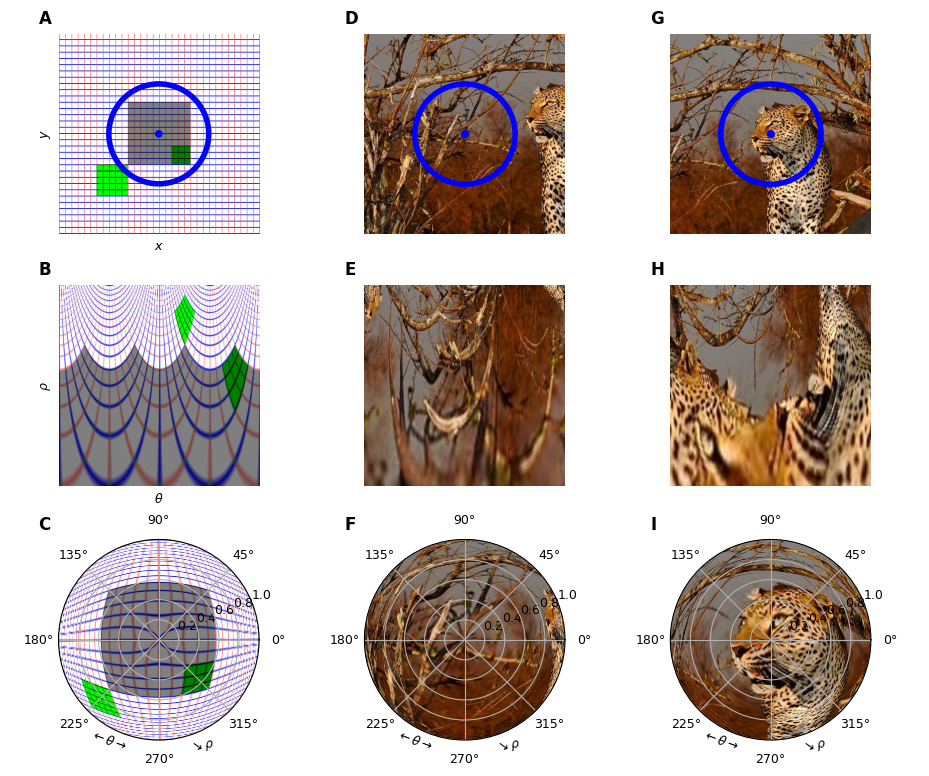

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(fig_width, fig_width*5/6), layout="constrained")
from matplotlib.patches import Circle

fontsize_letters = 12
fontsize_labels = 9

ax = axs[0][0]
ax.imshow(image_grid)
color = 'b'
circ = Circle((image_size_grid//2, image_size_grid//2), radius=(image_size_grid//60), edgecolor=color, facecolor=color)
ax.add_patch(circ)
circ = Circle((image_size_grid//2, image_size_grid//2), radius=(image_size_grid//4), lw=4, edgecolor=color, facecolor='none')
ax.add_patch(circ)
ax.text(-.1, 1.05, 'A', fontsize=fontsize_letters, color='black', weight='bold', transform=ax.transAxes)
ax.set_xlabel(r'$x$', fontsize=fontsize_labels)
ax.set_ylabel(r'$y$', fontsize=fontsize_labels)
# ax = axs[1][0]

ax = axs[1][0]
ax.imshow(image_grid_ret)
ax.text(-.1, 1.05, 'B', fontsize=fontsize_letters, color='black', weight='bold', transform=ax.transAxes)
ax.set_xlabel(r'$\theta$', fontsize=fontsize_labels)
ax.set_ylabel(r'$\rho$', fontsize=fontsize_labels)

ax = fig.add_subplot(3, 3, 7, polar=True)
m = ax.pcolormesh(Phi, R, np.flipud(image_grid_ret), shading='gouraud', vmin=image_grid_ret.min(), vmax=image_grid_ret.max(), 
                  edgecolors='none', linewidth=0)

# ax.imshow(image_grid_ret)
ax.text(-.1, 1.05, 'C', fontsize=fontsize_letters, color='black', weight='bold', transform=ax.transAxes)
ax.text(.15, -.05, r'$\leftarrow\theta\rightarrow$', fontsize=fontsize_labels, color='black', transform=ax.transAxes, rotation=-20)
ax.text(.65, -.05, r'$\searrow \rho$', fontsize=fontsize_labels, color='black', transform=ax.transAxes, rotation=10)
plt.tick_params(axis='both', labelsize=fontsize_labels)



ax = axs[0][1]
ax.imshow(image)
circ = Circle((image_size//2, image_size//2), radius=(image_size//60), edgecolor=color, facecolor=color)
ax.add_patch(circ)
circ = Circle((image_size//2, image_size//2), radius=(image_size//4), lw=4, edgecolor=color, facecolor='none')
ax.add_patch(circ)
ax.text(-.1, 1.05, 'D', fontsize=fontsize_letters, color='black', weight='bold', transform=ax.transAxes)
# ax = axs[1][1]

ax = axs[1][1]
ax.imshow(image_ret)
ax.text(-.1, 1.05, 'E', fontsize=fontsize_letters, color='black', weight='bold', transform=ax.transAxes)

ax = fig.add_subplot(3, 3, 8, polar=True)
m = ax.pcolormesh(Phi, R, np.flipud(image_ret), shading='gouraud', vmin=image_ret.min(), vmax=image_ret.max(), 
                  edgecolors='none', linewidth=0)
# ax.imshow(image_ret)
ax.text(.15, -.05, r'$\leftarrow\theta\rightarrow$', fontsize=fontsize_labels, color='black', transform=ax.transAxes, rotation=-20)
ax.text(.65, -.05, r'$\searrow \rho$', fontsize=fontsize_labels, color='black', transform=ax.transAxes, rotation=10)
ax.text(-.1, 1.05, 'F', fontsize=fontsize_letters, color='black', weight='bold', transform=ax.transAxes)
plt.tick_params(axis='both', labelsize=fontsize_labels)




ax = axs[0][2]
ax.imshow(image_shift)
circ = Circle((image_size//2, image_size//2), radius=(image_size//60), edgecolor=color, facecolor=color)
ax.add_patch(circ)
circ = Circle((image_size//2, image_size//2), radius=(image_size//4), lw=4, edgecolor=color, facecolor='none')
ax.add_patch(circ)
ax.text(-.1, 1.05, 'G', fontsize=fontsize_letters, color='black', weight='bold', transform=ax.transAxes)
# ax = axs[1][2]

ax = axs[1][2]
ax.imshow(image_ret_shift)
ax.text(-.1, 1.05, 'H', fontsize=fontsize_letters, color='black', weight='bold', transform=ax.transAxes)

ax = fig.add_subplot(3, 3, 9, polar=True)
m = ax.pcolormesh(Phi, R, np.flipud(image_ret_shift), shading='gouraud', vmin=image_ret_shift.min(), vmax=image_ret_shift.max(), 
                  edgecolors='none', linewidth=0)

ax.text(.15, -.05, r'$\leftarrow\theta\rightarrow$', fontsize=fontsize_labels, color='black', transform=ax.transAxes, rotation=-20)
ax.text(.65, -.05, r'$\searrow \rho$', fontsize=fontsize_labels, color='black', transform=ax.transAxes, rotation=10)
ax.text(-.1, 1.05, 'I', fontsize=fontsize_letters, color='black', weight='bold', transform=ax.transAxes)
plt.tick_params(axis='both', labelsize=fontsize_labels)

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

fig.set_facecolor(color='white')


In [ ]:

fovea.savefig(fig, name='30_logpolar', figures_folder=args.figures_folder, exts=['jpg'])

# if do_save: to_save(fig, name='fig-logpolar', exts=['pdf', 'png', 'jpg'])

FileNotFoundError: [Errno 2] No such file or directory: 'figs/fig-logpolar.pdf'


## movies illustrating the properties of the log-polar transform

In [ ]:
from retinotopy import make_mp4

In [ ]:
from torchvision.transforms import RandomAffine

In [ ]:
def create_fig(theta=np.pi/4, scale=1):

    image_grid_size = 8
    image_grid_tens = torch.ones((3, image_size_grid, image_size_grid)).float()
    fovea_size = 5
    image_square_tens = torch.ones((3, image_size_grid, image_size_grid)).float()
    image_square_tens[[1, 0],  # green square
                    int(image_size_grid//2+image_grid_size*fovea_size/2.5):int(image_size_grid//2+image_grid_size*fovea_size), 
                    int(image_size_grid//2+image_grid_size*fovea_size/2.5):int(image_size_grid//2+image_grid_size*fovea_size), 
                    ] = 0
    
    transform = RandomAffine(degrees=(theta*180/np.pi, theta*180/np.pi+0.01), scale=(scale, scale))
    image_square_tens = transform(image_square_tens)
    
    image_grid_tens[[0, 2], :, :] = image_square_tens[[0, 2], :, :]

    image_grid_tens[[0, 2], 
                    int(image_size_grid//2+image_grid_size*fovea_size):int(image_size_grid//2+image_grid_size*fovea_size*2.5), 
                    int(image_size_grid//2-image_grid_size*fovea_size*2.5):int(image_size_grid//2-image_grid_size*fovea_size), 
                    ] = 0
    
    image_grid_tens[0:2, ::image_grid_size, :] = 0 # grid H
    image_grid_tens[1:3, :, ::image_grid_size] = 0 # grid V
    image_grid_tens[:, (image_size_grid//2-image_grid_size*fovea_size):(image_size_grid//2+image_grid_size*fovea_size), (image_size_grid//2-image_grid_size*fovea_size):(image_size_grid//2+image_grid_size*fovea_size)] *= .5 # fovea

    image_grid = image_grid_tens.squeeze(0)
    # swap from C, H, W (torch) to H, W, C (numpy)
    image_grid = torch.movedim(image_grid, (1, 2, 0), (0, 1, 2))
    image_grid = image_grid.numpy()
    
    image_grid_ret_tens = F.grid_sample(image_grid_tens.unsqueeze(0).float(), logPolar_grid, align_corners=False, padding_mode='border')
    image_grid_ret_tens = image_grid_ret_tens.squeeze(0)
    # swap from C, H, W (torch) to H, W, C (numpy)
    image_grid_ret_tens = torch.movedim(image_grid_ret_tens, (1, 2, 0), (0, 1, 2))
    image_grid_ret = image_grid_ret_tens.numpy()
    image_grid_ret /= image_grid_ret.max()
    

    fig, axs = plt.subplots(1, 3, figsize=(fig_width, fig_width/3))
    from matplotlib.patches import Circle

    ax = axs[0]
    ax.imshow(image_grid)
    # ax.plot(image_size//2, image_size//2, 'r+', markersize=20, markeredgewidth=2)
    color = 'b'
    circ = Circle((image_size_grid//2, image_size_grid//2), radius=(image_size_grid//60), edgecolor=color, facecolor=color)
    ax.add_patch(circ)
    circ = Circle((image_size_grid//2, image_size_grid//2), radius=(image_size_grid//4), lw=4, edgecolor=color, facecolor='none')
    ax.add_patch(circ)
    ax.text(-.1, 1.05, 'A', fontsize=fontsize_letters, color='black', transform=ax.transAxes)
    # ax.plot(image_size_grid//2, image_size_grid//2, 'r+', markersize=20, markeredgewidth=2)
    ax.set_xlabel(r'$x$', fontsize=fontsize_labels)
    ax.set_ylabel(r'$y$', fontsize=fontsize_labels)
    
    ax = axs[1]
    ax.imshow(image_grid_ret)
    ax.text(-.1, 1.05, 'B', fontsize=fontsize_letters, color='black', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta$', fontsize=fontsize_labels)
    ax.set_ylabel(r'$\rho$', fontsize=fontsize_labels)

    ax = fig.add_subplot(1, 3, 3, polar=True)
    m = ax.pcolormesh(Phi, R, np.flipud(image_grid_ret), shading='gouraud', vmin=image_ret.min(), vmax=image_ret.max(), 
                    edgecolors='none', linewidth=0)
    # ax.imshow(image_ret)
    ax.text(.15, -.05, r'$\leftarrow\theta\rightarrow$', fontsize=fontsize_labels, color='black', transform=ax.transAxes, rotation=-20)
    ax.text(.65, -.05, r'$\searrow \rho$', fontsize=fontsize_labels, color='black', transform=ax.transAxes, rotation=10)
    ax.text(-.1, 1.05, 'C', fontsize=fontsize_letters, color='black', transform=ax.transAxes)
    # for tick in ax.xaxis.get_major_ticks():
    #     tick.label.set_fontsize(fontsize_labels) 
    plt.tick_params(axis='both', labelsize=fontsize_labels)

    for ax in axs.ravel():
        ax.set_xticks([])
        # ax.set_xticklabels([])
        ax.set_yticks([])  
        for spine in ax.spines.values():
            spine.set_visible(False)
    fig.set_facecolor(color='white')
    return fig

fig = create_fig(theta=-np.pi/2, scale=2.5)

In [ ]:
from tqdm import tqdm, trange

n_frame = 150
fnames = []
for i_frame in trange(n_frame):
    fname = f'/tmp/frame_{i_frame:04d}.png'
    fig = create_fig(theta=np.pi/2 + i_frame*2*np.pi/n_frame, scale=2.5+np.sin(i_frame*2*np.pi/n_frame))
    fig.savefig(fname)
    fnames.append(fname)
    plt.close(fig)

mp4name = make_mp4('figs/grid.mp4', fnames, fps=15)


## Appendix: version of the libraries that were used